In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib
# import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import sys
sys.path.append('../')

#import pretrainedmodels
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from gated import *
from resnet import *

In [2]:
# !pip install pretrainedmodels

In [3]:
# device = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float

epochs = 20
BATCH_SIZE = 64

In [4]:
image_paths = list(paths.list_images('../data/101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [5]:
len(set(labels))

101

In [6]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")


Total number of classes: 101


In [7]:
# define transforms
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [8]:
# divide the data into train, validation, and test set
(x_train, x_val , y_train, y_val) = train_test_split(data, labels, 
                                                    test_size=0.3,  
                                                    stratify=labels,
                                                    random_state=42)

(x_val, x_test, y_val, y_test) = train_test_split(x_val, y_val, 
                                                    test_size=0.65, 
                                                    random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (6073,)
x_test examples: (1693,)
x_val examples: (911,)


In [9]:
np.argmax(y_val[:20], axis=-1)

array([98,  3, 65, 52,  0,  1, 71, 72,  3,  3, 23,  3,  1, 55,  1, 11, 17,
       40, 90, 53])

In [10]:
# custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

In [11]:
# dataloaders
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
model = resnet18(pretrained=False).to(device)

dilation [False, False, False]
stride 1
downsample
stride 2
downsample
stride 2
downsample
stride 2


In [13]:
# model.eval()
for i in model.parameters():
    pass
#     print(i.shape)
#     print((i[0].type()))
state_dict = model.state_dict()
for i in state_dict :
    print(i)
#     if 'conv1.weight' in i :
#         print(state_dict[i][0,0])

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn1.running_mean
layer2.0.bn1.running_var
layer2.0.bn1.num_batches_tracked
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.bn2.running_mean
layer2.0.bn2.running_var
layer2.0.bn2.num_batches_tracked
layer2.0.downsample.0.weight
layer2.0.downsamp

In [14]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [15]:
# training function
def fit(model, dataloader):
#     print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target, 1)[1])
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

In [16]:
#validation function
def validate(model, dataloader):
#     print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        
        return loss, accuracy

In [17]:
def test(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, target = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == torch.max(target, 1)[1]).sum().item()
    return correct, total

  0%|          | 0/94 [00:00<?, ?it/s]

Training on 6073 examples, validating on 911 examples...


95it [00:17,  5.53it/s]                        
  7%|▋         | 1/14 [00:00<00:01,  6.70it/s]

Train Loss: 0.0505, Train Acc: 32.18


15it [00:01,  7.76it/s]                        
  1%|          | 1/94 [00:00<00:12,  7.68it/s]

Val Loss: 0.0499, Val Acc: 36.33


95it [00:16,  5.68it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.31it/s]

Train Loss: 0.0392, Train Acc: 42.88


15it [00:02,  7.35it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.64it/s]

Val Loss: 0.0402, Val Acc: 46.21


95it [00:17,  5.58it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.41it/s]

Train Loss: 0.0325, Train Acc: 50.91


15it [00:02,  7.24it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.48it/s]

Val Loss: 0.0353, Val Acc: 50.05


95it [00:16,  5.62it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.35it/s]

Train Loss: 0.0271, Train Acc: 58.06


15it [00:02,  6.85it/s]                        
  1%|          | 1/94 [00:00<00:13,  6.73it/s]

Val Loss: 0.0328, Val Acc: 52.80


95it [00:16,  5.86it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.33it/s]

Train Loss: 0.0220, Train Acc: 65.12


15it [00:02,  7.06it/s]                        
  1%|          | 1/94 [00:00<00:16,  5.65it/s]

Val Loss: 0.0273, Val Acc: 58.07


95it [00:16,  5.60it/s]                        
  7%|▋         | 1/14 [00:00<00:01,  6.79it/s]

Train Loss: 0.0174, Train Acc: 72.11


15it [00:02,  7.33it/s]                        
  1%|          | 1/94 [00:00<00:13,  6.89it/s]

Val Loss: 0.0323, Val Acc: 54.99


95it [00:17,  5.57it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.30it/s]

Train Loss: 0.0136, Train Acc: 77.62


15it [00:01,  7.97it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.51it/s]

Val Loss: 0.0247, Val Acc: 62.46


95it [00:17,  5.58it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.18it/s]

Train Loss: 0.0097, Train Acc: 85.05


15it [00:01,  7.98it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.56it/s]

Val Loss: 0.0203, Val Acc: 67.51


95it [00:17,  5.57it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.15it/s]

Train Loss: 0.0064, Train Acc: 90.98


15it [00:02,  7.33it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.64it/s]

Val Loss: 0.0259, Val Acc: 61.58


95it [00:16,  5.82it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.17it/s]

Train Loss: 0.0038, Train Acc: 95.27


15it [00:02,  7.26it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.53it/s]

Val Loss: 0.0220, Val Acc: 66.85


95it [00:17,  5.56it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.41it/s]

Train Loss: 0.0018, Train Acc: 98.35


15it [00:02,  7.22it/s]                        
  1%|          | 1/94 [00:00<00:13,  6.81it/s]

Val Loss: 0.0201, Val Acc: 69.26


95it [00:17,  5.58it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.25it/s]

Train Loss: 0.0007, Train Acc: 99.72


15it [00:01,  7.69it/s]                        
  1%|          | 1/94 [00:00<00:11,  7.85it/s]

Val Loss: 0.0175, Val Acc: 71.90


95it [00:17,  5.57it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.28it/s]

Train Loss: 0.0004, Train Acc: 99.84


15it [00:02,  7.23it/s]                        
  0%|          | 0/94 [00:00<?, ?it/s]

Val Loss: 0.0165, Val Acc: 75.52


95it [00:17,  5.56it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.15it/s]

Train Loss: 0.0002, Train Acc: 99.97


15it [00:02,  7.09it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.47it/s]

Val Loss: 0.0145, Val Acc: 76.18


95it [00:17,  5.58it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.27it/s]

Train Loss: 0.0001, Train Acc: 99.98


15it [00:01,  7.70it/s]                        
  1%|          | 1/94 [00:00<00:16,  5.77it/s]

Val Loss: 0.0144, Val Acc: 76.29


95it [00:17,  5.59it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.30it/s]

Train Loss: 0.0001, Train Acc: 99.98


15it [00:02,  7.02it/s]                        
  1%|          | 1/94 [00:00<00:14,  6.52it/s]

Val Loss: 0.0139, Val Acc: 76.84


95it [00:17,  5.58it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.28it/s]

Train Loss: 0.0001, Train Acc: 99.98


15it [00:02,  6.76it/s]                        
  1%|          | 1/94 [00:00<00:16,  5.60it/s]

Val Loss: 0.0144, Val Acc: 77.72


95it [00:17,  5.56it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.19it/s]

Train Loss: 0.0001, Train Acc: 99.97


15it [00:02,  7.27it/s]                        
  1%|          | 1/94 [00:00<00:13,  6.72it/s]

Val Loss: 0.0146, Val Acc: 77.39


95it [00:17,  5.58it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.08it/s]

Train Loss: 0.0000, Train Acc: 99.97


15it [00:02,  6.29it/s]                        
  0%|          | 0/94 [00:00<?, ?it/s]

Val Loss: 0.0148, Val Acc: 77.94


95it [00:17,  5.57it/s]                        
  7%|▋         | 1/14 [00:00<00:02,  6.17it/s]

Train Loss: 0.0000, Train Acc: 99.98


15it [00:02,  7.20it/s]                        


Val Loss: 0.0142, Val Acc: 77.39
6.339129050572713 minutes


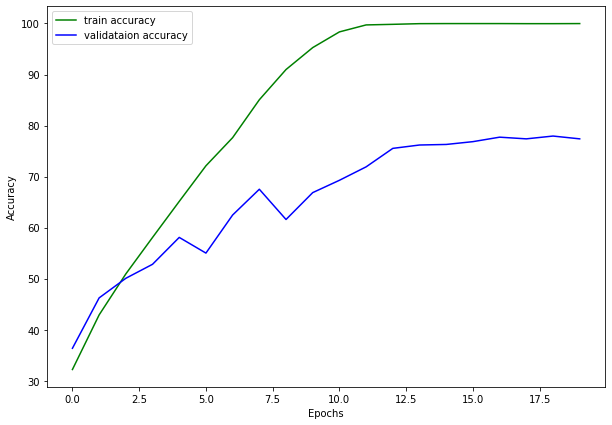

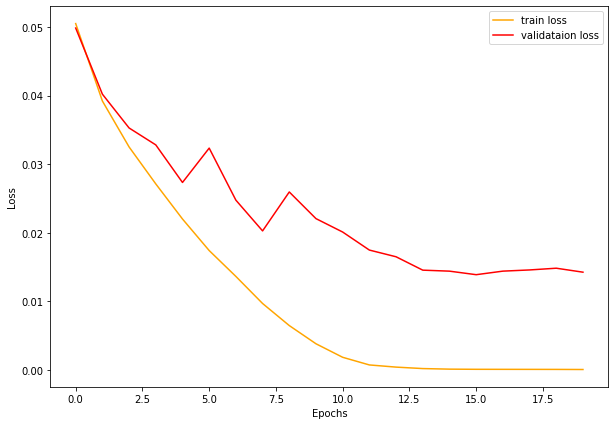

In [18]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
start = time.time()
for epoch in range(epochs):
#     print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')
torch.save(model.state_dict(), f"../trained_models/resnet18_epochs{epochs}.pth")
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../outputs/plots/accuracy.png')
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/plots/loss.png')

In [19]:
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))
print('train.py finished running')

Accuracy of the network on test images: 77.909 %
train.py finished running


In [20]:
state_dict = model.state_dict()
for i in state_dict :
#     print(i)
    if 'conv1.weight' in i :
        print(state_dict[i][0,0])

tensor([[ 0.0387,  0.0447,  0.0285,  0.0612,  0.0390,  0.0093, -0.0275],
        [ 0.0381,  0.0276, -0.0301,  0.0229,  0.0022,  0.0126, -0.0157],
        [-0.0003, -0.0202,  0.0218,  0.0390, -0.0031,  0.0259,  0.0161],
        [-0.0268,  0.0190,  0.0291, -0.0199, -0.0107,  0.0112,  0.0194],
        [-0.0114,  0.0321, -0.0160, -0.0091,  0.0039,  0.0327, -0.0091],
        [ 0.0198,  0.0201, -0.0148,  0.0104,  0.0035,  0.0130, -0.0172],
        [-0.0257, -0.0370, -0.0421, -0.0057, -0.0057, -0.0189, -0.0149]],
       device='cuda:0')
tensor([[-0.0788,  0.0473, -0.0536],
        [-0.0012, -0.0761, -0.0128],
        [-0.0421, -0.0090, -0.0623]], device='cuda:0')
tensor([[-0.0220, -0.0208, -0.0574],
        [-0.1021, -0.0416, -0.0444],
        [-0.1971,  0.0315,  0.0229]], device='cuda:0')
tensor([[ 0.0403, -0.0245,  0.0284],
        [ 0.0669,  0.0307,  0.0423],
        [ 0.0870, -0.0629,  0.0181]], device='cuda:0')
tensor([[-0.0287,  0.0141, -0.0368],
        [-0.0036,  0.0551, -0.0652],
   